<a href="https://colab.research.google.com/github/ArunGovardhanRajObuli/Projects/blob/main/Natural%20Language%20Processing%20Project/Natural_Language_Processing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Character-Based Text Similarity and Retrieval Evaluation using Cosine Similarity**

In this section we process character dialogue data from training, validation, and test datasets to evaluate how well character documents (constructed from lines of dialogue) can be matched across datasets using cosine similarity between feature vectors derived from tokenized and lemmatized text.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079
lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  

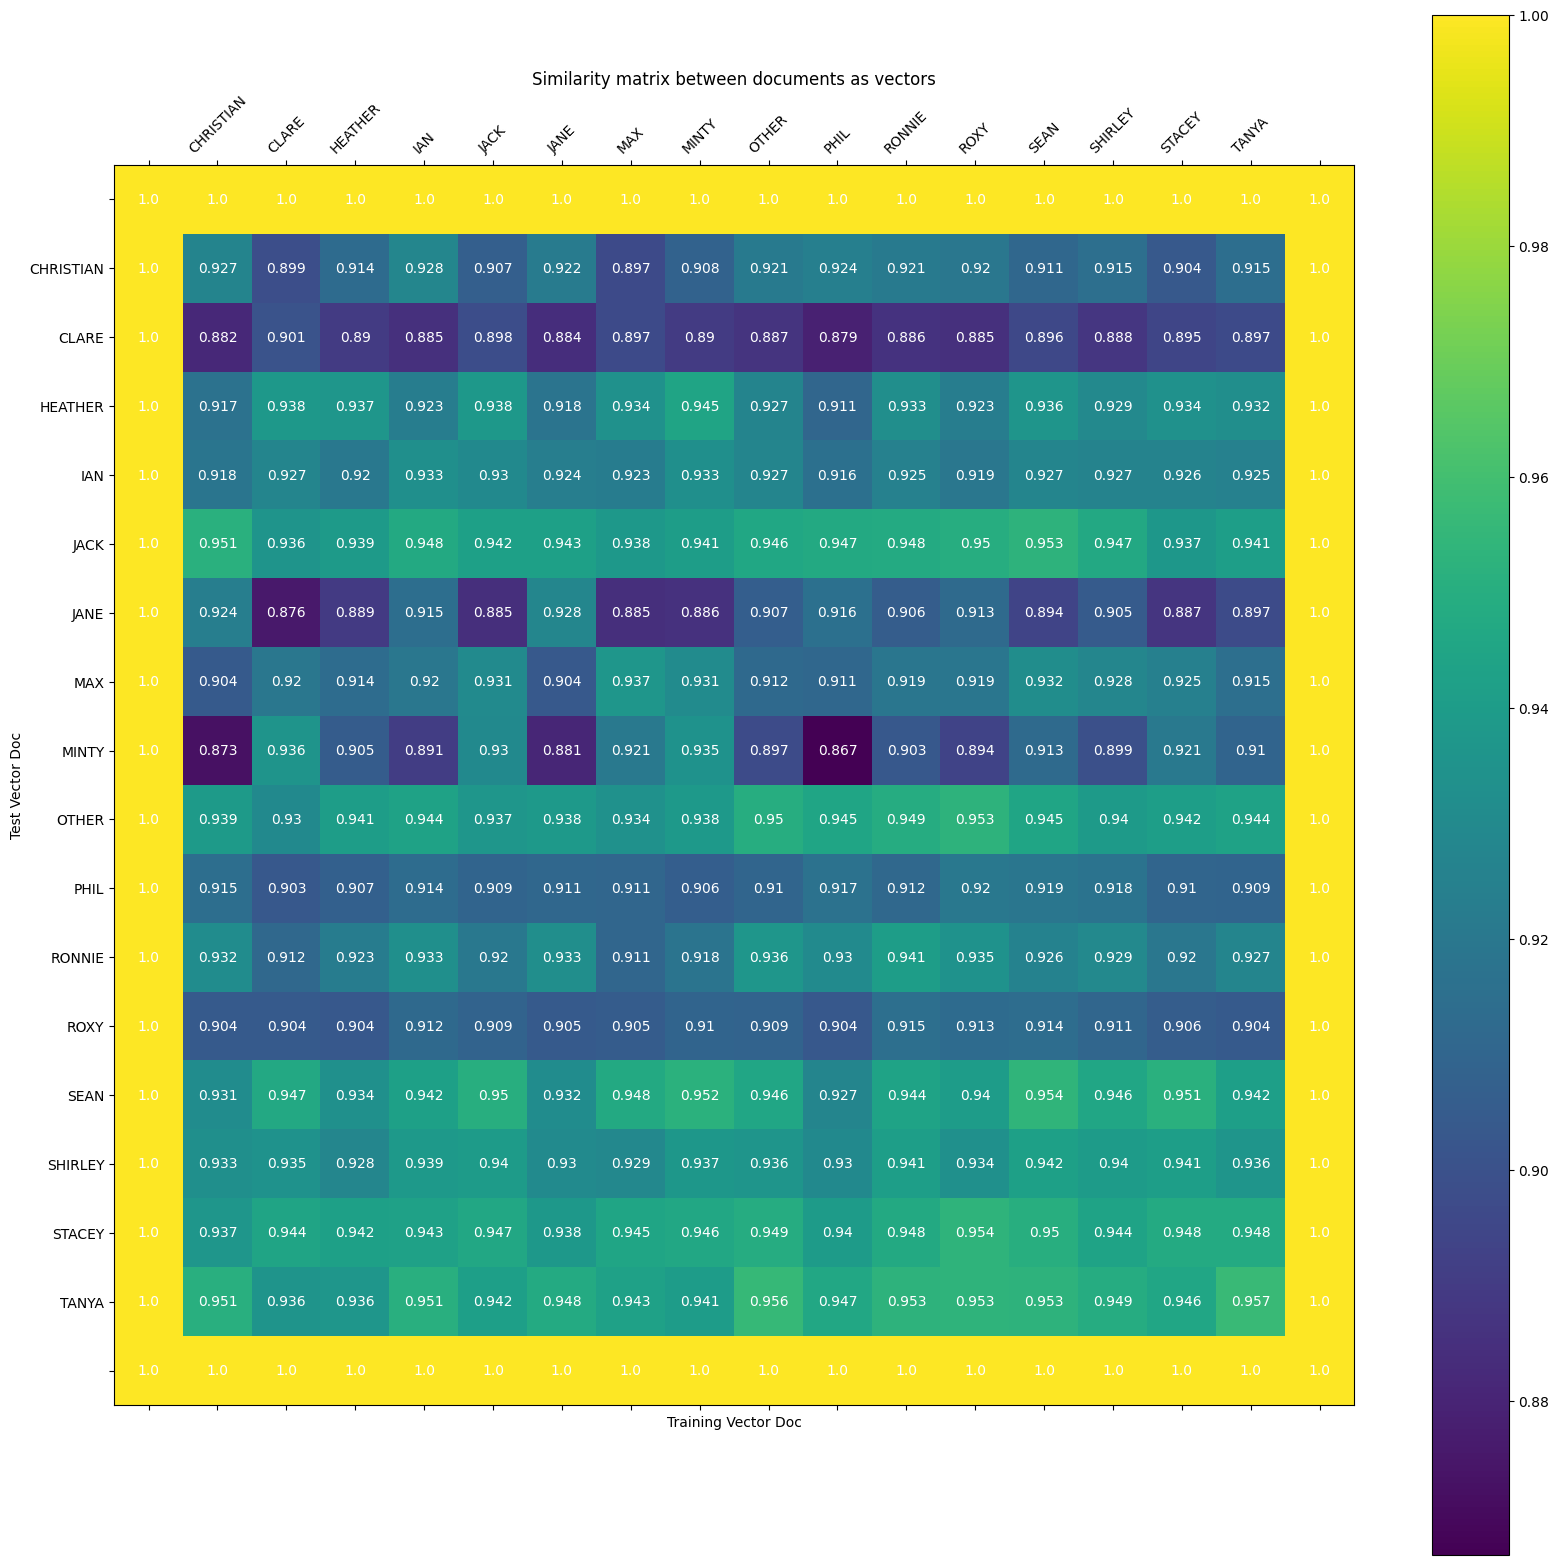

In [ ]:
!pip install nltk

import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)


def create_character_document_from_dataframe(df, max_line_count):

    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs


train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)


def pre_process(character_text):

    text = character_text.lower() # We convert all characters in the text to lowercase.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', character_text) # We remove all the special characters and punctuations.
    tokens = word_tokenize(text) # Converting the text into tokens.

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words] # We remove the common stopwords from the tokens.

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # We lemmatize the words which reduces them to their base forms.

    return tokens


training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]


def to_feature_vector_dictionary(character_doc, extra_features):

    counts = Counter(character_doc)
    counts = dict(counts)
    for feature in extra_features:
        counts[feature] += 1
    return counts


corpusVectorizer = DictVectorizer()


def create_document_matrix_from_corpus(corpus, fitting=False):

    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)


val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]


val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

def compute_cosine_similarity(v1, v2):

    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity


def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):

    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)


def plot_heat_map_similarity(df):

    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    plt.show()

print('\n')
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

# **Enhanced Character Document Retrieval with TF-IDF, N-grams, POS Features, and Chi-Square Feature Selection**

In this section we add bigrams & trigrams and POS tags to the token features (previously we used only unigrams only).

We also apply a TfidfTransformer to reweight features (previously we used raw counts).

We use SelectKBest(chi², k=500) to keep the most discriminative features (previously we used no selection).

We still compute cosine similarity, rank training docs for each validation doc, report mean rank/accuracy, and plot a similarity heatmap—but now over the enriched, TF-IDF-weighted, feature-selected vectors.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079
lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  

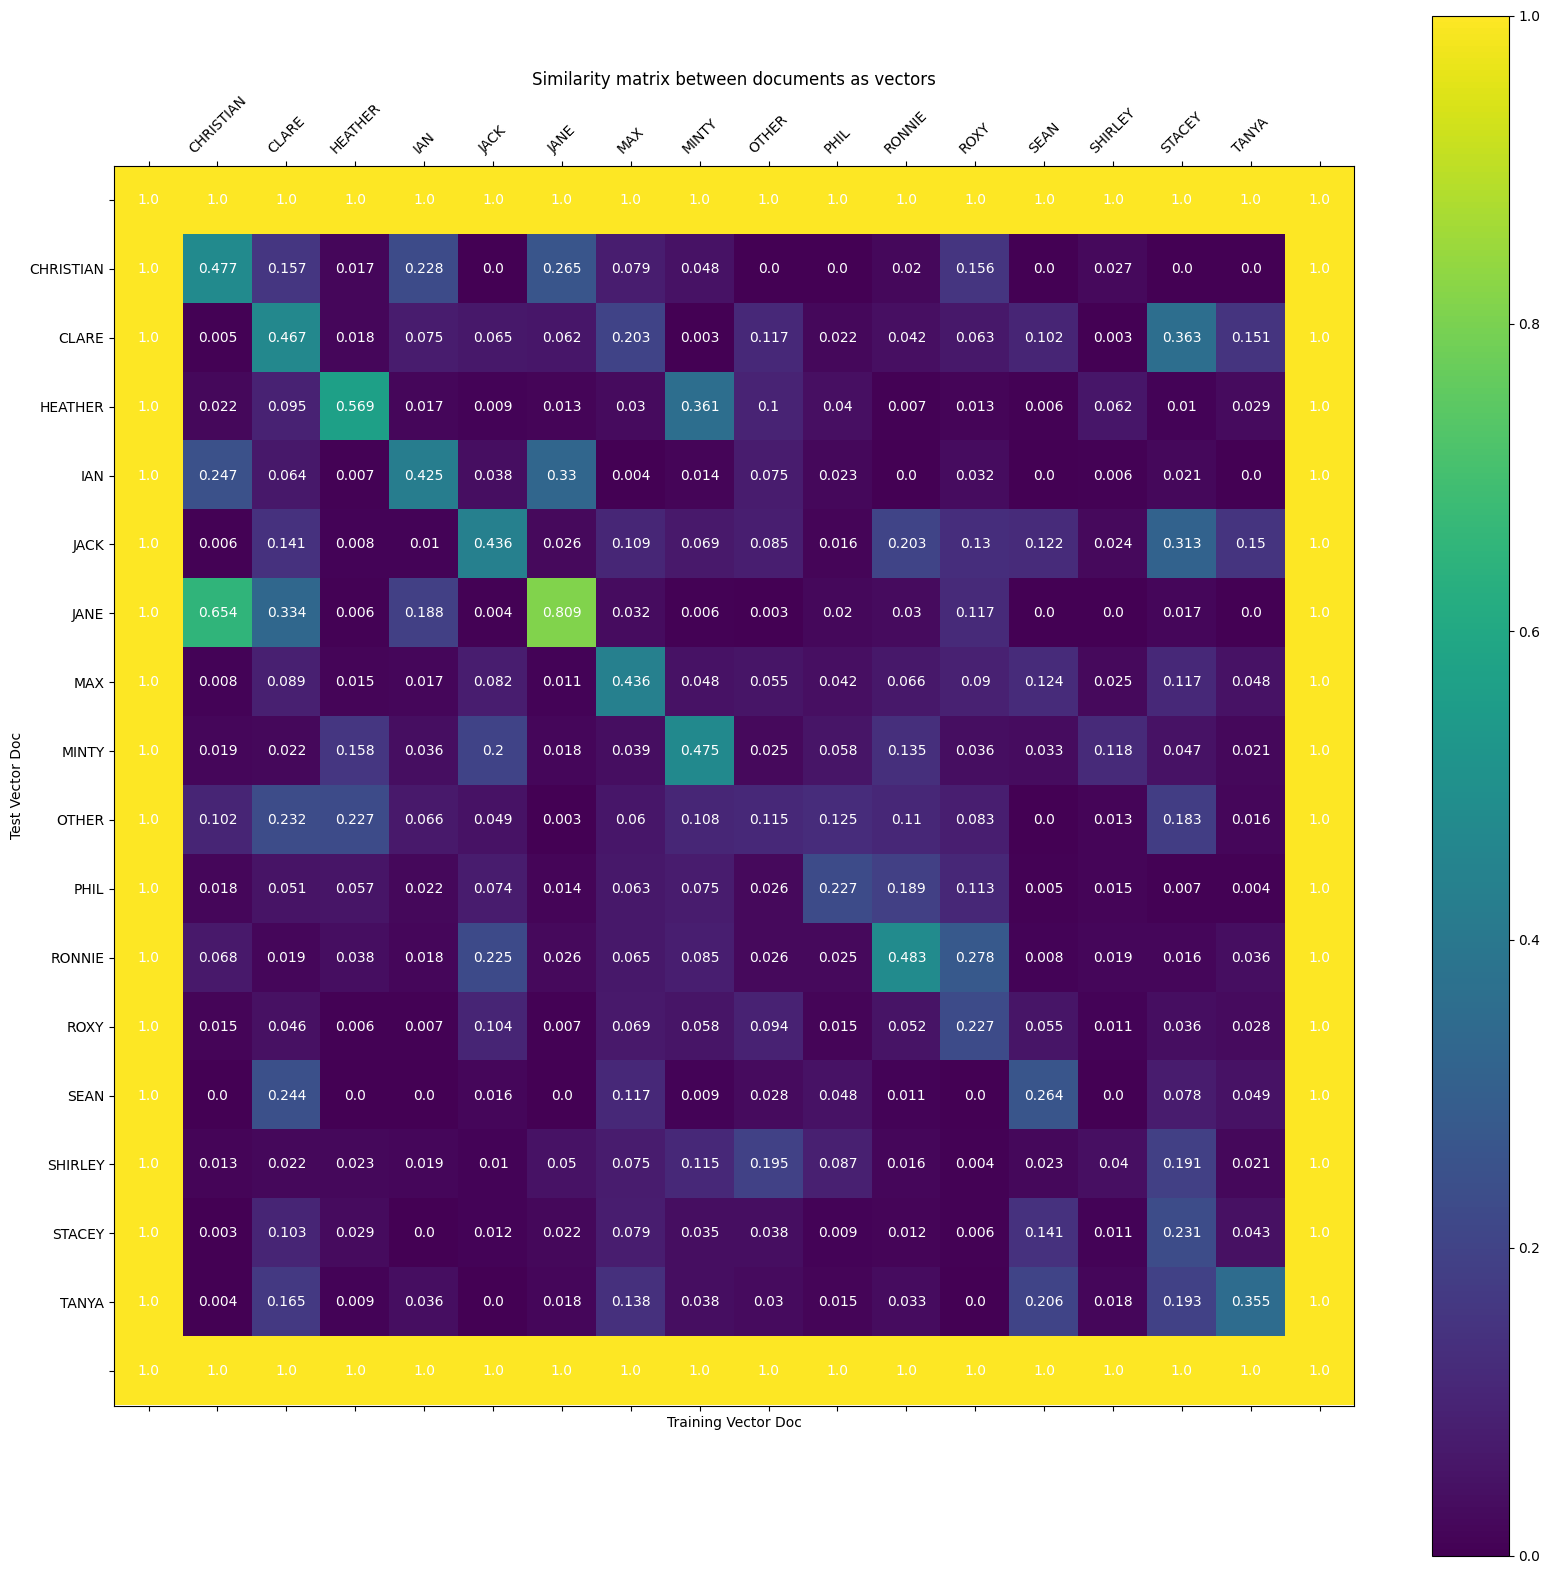

In [ ]:
!pip install nltk

import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
import seaborn as sns
import matplotlib.pyplot as plt

import math

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2


%matplotlib inline
pd.options.display.max_colwidth=500

train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

def create_character_document_from_dataframe(df, max_line_count):

    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs


train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)


def pre_process(character_text):

    text = character_text.lower() # We convert all characters in the text to lowercase.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', character_text) # We remove all the special characters and punctuations.
    tokens = word_tokenize(text) # Converting the text into tokens.

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words] # We remove the common stopwords from the tokens.

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # We lemmatize the words which reduces them to their base forms.

    return tokens


training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]



def to_feature_vector_dictionary(character_doc, extra_features=None):

    if extra_features is None:
        extra_features = []

    counts = Counter() # Initializing the counter.

    counts.update(character_doc) # We are adding individual tokens to the Counter.

    bigrams = [' '.join(g) for g in ngrams(character_doc, 2)] # We are adding bigrams.
    trigrams = [' '.join(g) for g in ngrams(character_doc, 3)] # We are adding trigrams.
    counts.update(bigrams)
    counts.update(trigrams)

    tags = [tag for (_, tag) in pos_tag(character_doc)] # We add Part-of-Speech tags as features.
    counts.update(tags)

    for feat in extra_features:
        counts[feat] += 1

    return dict(counts)


corpusVectorizer = DictVectorizer()


# Initializing Global Variables.
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False):

    global feature_selector

    feature_dicts = [to_feature_vector_dictionary(doc, []) for name, doc in corpus] # Generating feature dictionaries for each document.

    if fitting:
        corpusVectorizer.fit(feature_dicts) # We fit the DictVectorizer on the feature dictionaries.
    doc_feature_matrix = corpusVectorizer.transform(feature_dicts) # Transforming feature dictionaries into a sparse matrix.

    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix) # Applying TF-IDF transformation to the document matrix.

    if fitting:
        feature_selector = SelectKBest(chi2, k=500) # Selecting the best k features using chi^2 test.
        feature_selector.fit(doc_feature_matrix, [name for name, doc in corpus]) # We are fitting the SelectKBest object to the document feature matrix and their corresponding labels.
    if feature_selector is not None:
        doc_feature_matrix = feature_selector.transform(doc_feature_matrix) # Applying the feature selection transformation to reduce the feature space of the document matrix.

    return doc_feature_matrix


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

def compute_cosine_similarity(v1, v2):

    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity


def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):

    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)


def plot_heat_map_similarity(df):

    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    plt.show()

print('\n')
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

# **Context-Aware Character Retrieval with Scene Augmentation, TF-IDF, N-grams, POS Tags, and Chi-Square Selection**

In this section we introduce scene/context augmentation, where character documents are built with episode and scene tokens (__EPISODE_X__ __SCENE_Y__) and optional context around each dialogue line.

We can include:

full_scene (all lines in the scene),

partial_scene (first 5 lines),

neighbouring_lines (+-k lines, default 2),

or no context (controlled with use_scene_context).

We also implement ordered dialog processing by sorting and grouping data by Episode and Scene, ensuring that dialogue sequences maintain their narrative order.

We add richer supervision signals through episode/scene markers, which act as contextual metadata to help distinguish similar characters across different scenes or episodes.

The feature extraction pipeline remains advanced—retaining unigrams, bigrams, trigrams, POS tags, TF-IDF weighting, and SelectKBest(χ², k=500) feature selection from the previous version.

Finally, we improve efficiency and clarity by precomputing dense arrays for cosine similarity, refining variable naming, removing redundant re-fitting steps, and adding descriptive docstrings for helper functions like the heatmap plotter.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  60470
OTHER Number of Words:  44303
JACK Number of Words:  57217
RONNIE Number of Words:  47828
ROXY Number of Words:  48000
TANYA Number of Words:  47110
SEAN Number of Words:  47949
MAX Number of Words:  55051
IAN Number of Words:  59186
JANE Number of Words:  56083
STACEY Number of Words:  51051
PHIL Number of Words:  61594
HEATHER Number of Words:  54807
MINTY Number of Words:  56835
CHRISTIAN Number of Words:  56427
CLARE Number of Words:  52777
Total words: 856688
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50

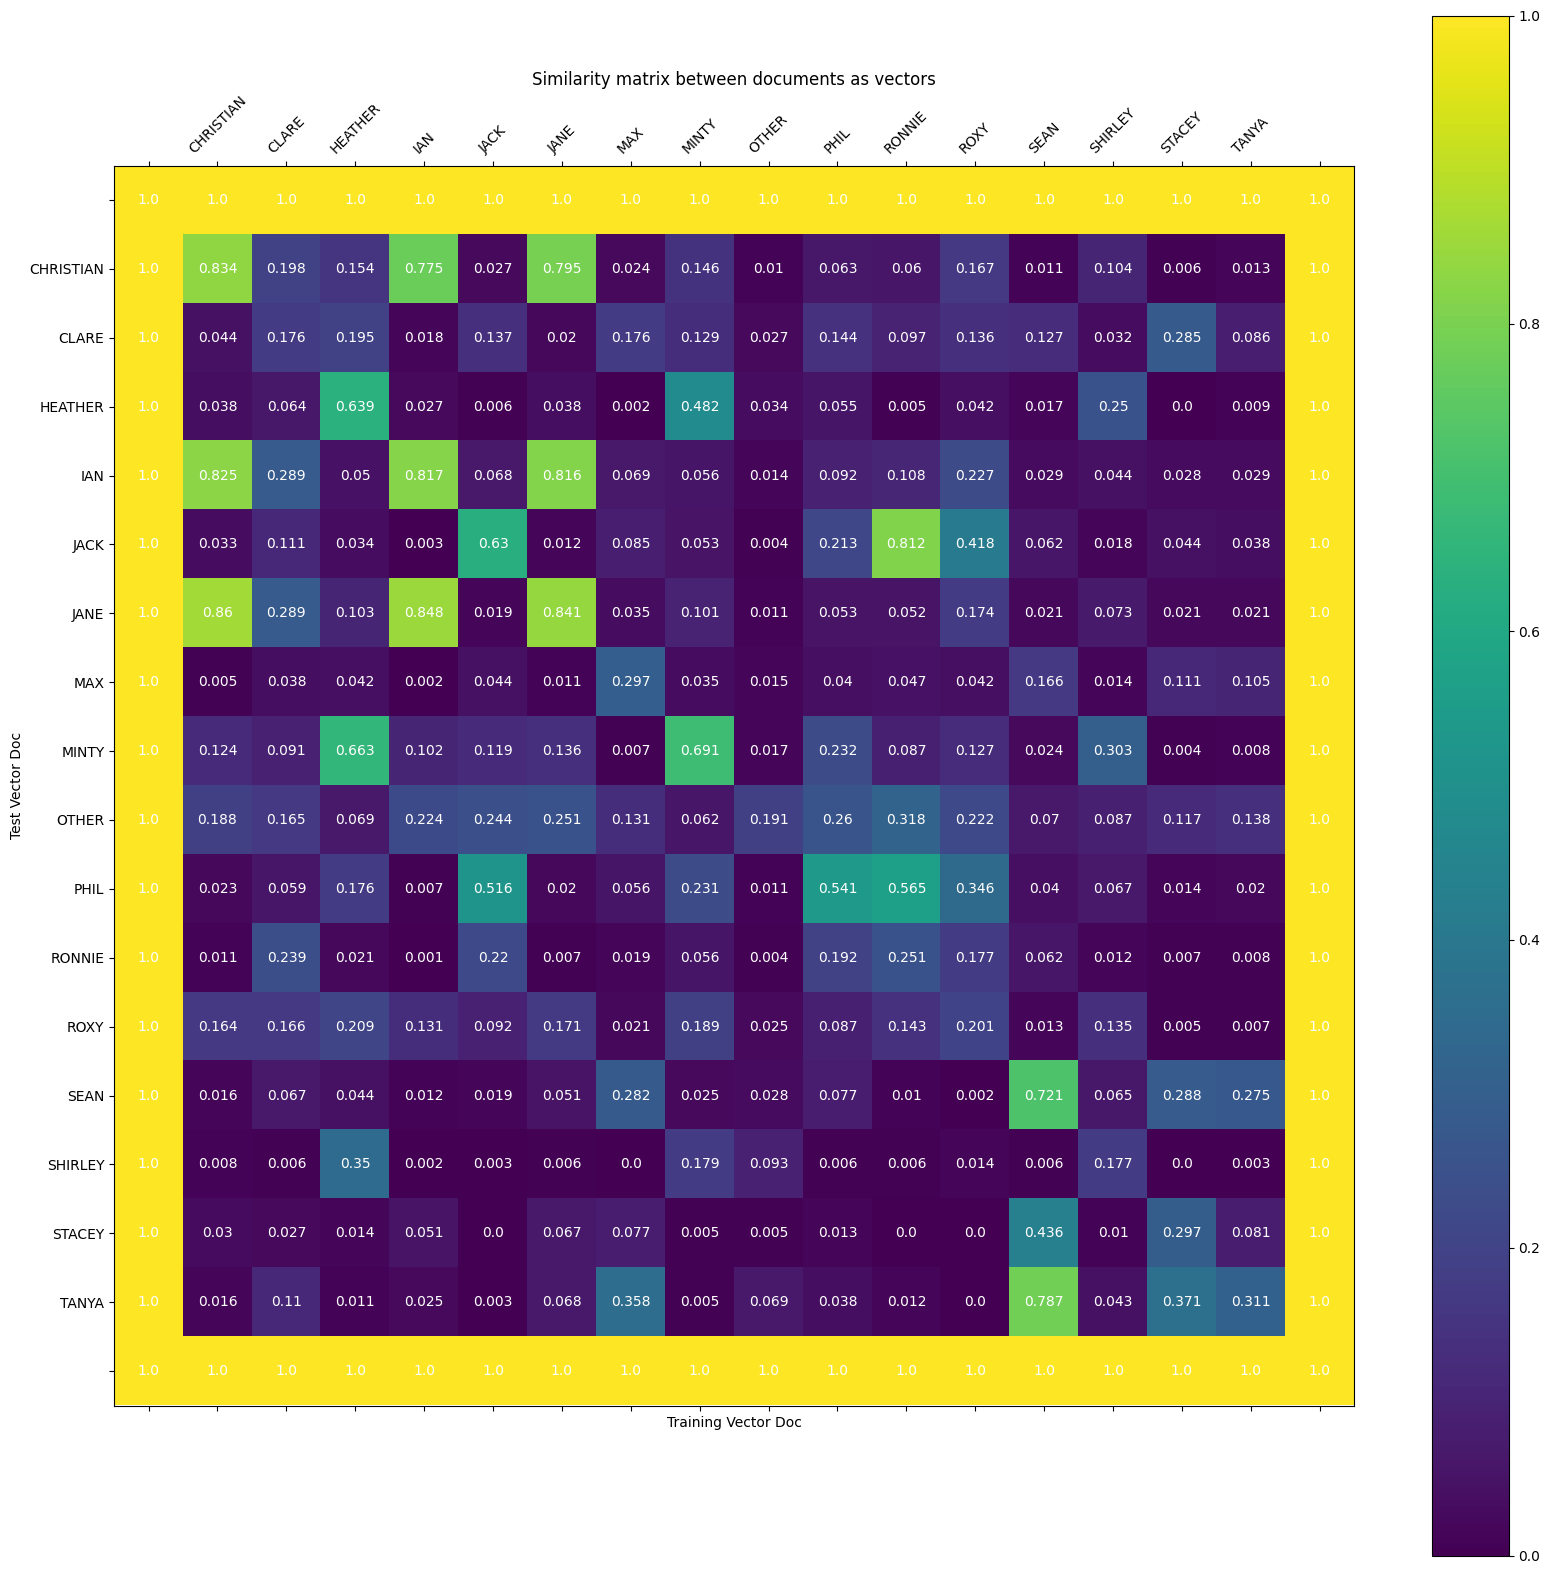

In [ ]:
!pip install nltk

import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2

%matplotlib inline
pd.options.display.max_colwidth=500

train_path = 'training.csv'
train_data = pd.read_csv(train_path, delimiter="\t", skip_blank_lines = True)
val_path = 'val.csv'
val_data = pd.read_csv(val_path, delimiter="\t", skip_blank_lines = True)
test_path = 'test.csv'
test_data = pd.read_csv(test_path, delimiter="\t", skip_blank_lines = True)



def create_character_document_from_dataframe(df, max_line_count, use_scene_context=True, context_mode="full_scene", neighbouring_line_count=2):


    df_sorted = df.sort_values(by=["Episode", "Scene"]) # We sort the dataframe by Episode and Scene. This ensures that the dialogues are processed in the correct order.

    grouped = df_sorted.groupby(["Episode", "Scene"], sort=False) # Grouping the sorted dataframe.

    character_docs = {} # Initializing dictionary to store aggregated dialogues for each character.
    character_line_count = {} # Initializing dictionary to store character lines for each character. It tracks the number of lines added per character to enforce the max_line_count limit.

    for (episode, scene), group_df in grouped: # We iterate over each scene group.

        lines = group_df["Line"].dropna().astype(str).str.strip().tolist() # We extract all the non empty dialogue lines and convert them to strings and remove the whitespaces.

        lines = [ln for ln in lines if ln] # Removing empty lines to ensure that only meaningful lines are processed.


        for position, (idx, row) in enumerate(group_df.iterrows()): # Iterating over each dialogue line within the current group, keeping track of the position.
            char_name = row["Character_name"] # We extract the name of the character speaking the line.
            line_text = row["Line"] # We extract the actual dialogue text.

            if not isinstance(line_text, str) or not line_text.strip(): # We skip preprocessing if the line is empty or not a string.
                continue

            # If the character is not already in the character_docs dictionary, we should initialize their entry.
            if char_name not in character_docs:
                character_docs[char_name] = "" # Initialize an empty string to store dialogues.
                character_line_count[char_name] = 0 # Initialize the line count for the character.

            # If the character has already reached the maximum number of lines, we skip adding more.
            if character_line_count[char_name] >= max_line_count:
                continue  # Skip if max lines reached.

            if use_scene_context:
                if context_mode == "full_scene":
                    context_text = " ".join(lines) # We add all lines in the scene to provide full context.
                elif context_mode == "partial_scene":
                    context_text = " ".join(lines[:5]) # We add only the first five lines of the scene for partial context.
                elif context_mode == "neighbouring_lines":
                    # Calculating the start and end indices to extract neighbouring lines around the current line.
                    start_idx = max(position - neighbouring_line_count, 0)  # Ensuring that the start_idx is not negative.
                    end_idx = min(position + neighbouring_line_count + 1, len(lines))  # Ensuring that the end_idx does not exceed list length.

                    context_lines = lines[start_idx:end_idx] # We are extracting the neighbouring lines based on the calculated indices.

                    context_text = " ".join(context_lines) # Combining the neighbouring lines into a single string.
                else:
                    context_text = " ".join(lines) # If an unknown context_mode is provided, default to full_scene context.
            else:
                context_text = "" # If use_scene_context is False, do not include any context.

            episode_scene_tokens = f"__EPISODE_{episode}__ __SCENE_{scene}__" # Creating tokens that identify the episode and scene.

            tokens_str = f"{episode_scene_tokens} {line_text}" # Combining the episode/scene tokens with the current line of dialogue.

            # Appending the determined context to the dialogue line based on the selected context_mode.
            if use_scene_context and context_mode in ["full_scene", "partial_scene", "neighbouring_lines"]:
                line_with_context = f"{tokens_str} {context_text} _EOL_ " # If scene context is used and the context_mode is recognized, include the context text.
            else:
                line_with_context = f"{tokens_str} _EOL_ " # If no context is used or the context_mode is unrecognized, append an end-of-line token.

            character_docs[char_name] += line_with_context # We add the processed line with or without context to the character's document.

            character_line_count[char_name] += 1 # Tracking the number of lines processed per character.

    print("Lines per character:", character_line_count)

    return character_docs



train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ', len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    word_count = len(train_character_docs[name].split())
    print(name, 'Number of Words: ', word_count)
    total_words += word_count
print("Total words:", total_words)


def pre_process(character_text):

    text = character_text.lower() # We convert all characters in the text to lowercase.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', character_text) # We remove all the special characters and punctuations.
    tokens = word_tokenize(text) # Converting the text into tokens.

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words] # We remove the common stopwords from the tokens.

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # We lemmatize the words which reduces them to their base forms.

    return tokens


training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for (name, _) in training_corpus]


def to_feature_vector_dictionary(character_doc, extra_features=None):

    if extra_features is None:
        extra_features = []

    counts = Counter() # Initializing the counter.

    counts.update(character_doc) # We are adding individual tokens to the Counter.

    bigrams = [' '.join(g) for g in ngrams(character_doc, 2)] # We are adding bigrams.
    trigrams = [' '.join(g) for g in ngrams(character_doc, 3)] # We are adding trigrams.
    counts.update(bigrams)
    counts.update(trigrams)

    tags = [tag for (_, tag) in pos_tag(character_doc)] # We add Part-of-Speech tags as features.
    counts.update(tags)

    for feat in extra_features:
        counts[feat] += 1

    return dict(counts)


# Global objects
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False):

    global feature_selector

    feature_dicts = [to_feature_vector_dictionary(doc, []) for name, doc in corpus] # Generating feature dictionaries for each document.

    if fitting:
        corpusVectorizer.fit(feature_dicts) # We fit the DictVectorizer on the feature dictionaries.
    doc_feature_matrix = corpusVectorizer.transform(feature_dicts) # Transforming feature dictionaries into a sparse matrix.

    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix) # Applying TF-IDF transformation to the document matrix.

    if fitting:
        feature_selector = SelectKBest(chi2, k=500) # Selecting the best k features using chi^2 test.
        feature_selector.fit(doc_feature_matrix, [name for name, doc in corpus]) # We are fitting the SelectKBest object to the document feature matrix and their corresponding labels.
    if feature_selector is not None:
        doc_feature_matrix = feature_selector.transform(doc_feature_matrix) # Applying the feature selection transformation to reduce the feature space of the document matrix.

    return doc_feature_matrix


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)



val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ', len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    word_count = len(val_character_docs[name].split())
    print(name, 'Num of Words: ', word_count)
    total_words += word_count
print("Total words:", total_words)

val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, _ in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)


def compute_cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0

    train_arr = train_feature_matrix.toarray()
    test_arr  = test_feature_matrix.toarray()

    for i, target_label in enumerate(test_labels):
        fm_1 = test_arr[i]
        all_sims = {}
        for j, train_label in enumerate(train_labels):
            fm_2 = train_arr[j]
            sim = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target_label, train_label))
            pairwise_cosine_similarity.append(sim)
            if train_label == target_label:
                all_cosine_similarities.append(sim)
            all_sims[train_label] = sim

        sorted_sims = sorted(all_sims.items(), key=lambda x: x[1], reverse=True)
        rank_dict = {key_val[0]: rank for rank, key_val in enumerate(sorted_sims, start=1)}

        if rank_dict[target_label] == 1:
            correct += 1
        rankings.append(rank_dict[target_label])

    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct / len(test_labels)
    print("Mean rank:", mean_rank)
    print("Mean cosine similarity:", mean_cosine_similarity)
    print(f"{correct} correct out of {len(test_labels)} => accuracy: {accuracy}")

    df = pd.DataFrame({
        'doc1': [x[0] for x in pairs],
        'doc2': [x[1] for x in pairs],
        'similarity': pairwise_cosine_similarity
    })
    return (mean_rank, mean_cosine_similarity, accuracy, df)


def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    plt.show()


print('\nEvaluation on Validation Data:\n')
mean_rank, mean_cosine_sim, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix,
    val_feature_matrix,
    train_labels,
    val_labels
)
plot_heat_map_similarity(df)


# **Grid Search**

**1. Grid Search on pre_process**

We perform a grid search over four preprocessing parameters:
do_lowercase, remove_punct, remove_stopwords, do_lemmatize

We test all combinations of these boolean options, compute mean rank scores using cosine similarity between validation and training sets, and identify the best preprocessing configuration for text cleaning.
(Previously, preprocessing parameters were fixed; now they are tuned empirically.)

In [ ]:
# Grid Search on pre_process (Q1)

def pre_process(text, do_lowercase=True, remove_punct=True, remove_stopwords=True, do_lemmatize=True):

    if do_lowercase:
        text = text.lower() # We convert all characters in the text to lowercase.

    if remove_punct:
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # We remove all the special characters and punctuations.

    tokens = word_tokenize(text) # Converting the text into tokens.

    if remove_stopwords:
        sw = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in sw] # We remove the common stopwords from the tokens.

    if do_lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens] # We lemmatize the words which reduces them to their base forms.

    return tokens

# We are defining the parameter grid manually
do_lowercase_options = [True, False]
remove_punct_options = [True, False]
remove_stopwords_options = [True, False]
do_lemmatize_options = [True, False]

best_parameters_q1 = None
best_mean_rank_q1 = float('inf')

# Iterating through all combinations of parameters.
for do_lowercase in do_lowercase_options:
    for remove_punct in remove_punct_options:
        for remove_stopwords in remove_stopwords_options:
            for do_lemmatize in do_lemmatize_options:
                params = {
                    'do_lowercase': do_lowercase,
                    'remove_punct': remove_punct,
                    'remove_stopwords': remove_stopwords,
                    'do_lemmatize': do_lemmatize
                }


                training_corpus_variant = []
                for name, doc in sorted(train_character_docs.items()):
                    tokens = pre_process(doc, do_lowercase=do_lowercase, remove_punct=remove_punct, remove_stopwords=remove_stopwords, do_lemmatize=do_lemmatize) # We preprocess training corpus.
                    training_corpus_variant.append((name, tokens))


                training_feature_matrix_variant = create_document_matrix_from_corpus(training_corpus_variant, fitting=True) # Creating feature matrix for training data.

                val_corpus_variant = []
                for name, doc in sorted(val_character_docs.items()):
                    tokens = pre_process( doc, do_lowercase=do_lowercase, remove_punct=remove_punct, remove_stopwords=remove_stopwords, do_lemmatize=do_lemmatize) # We preprocess training corpus.
                    val_corpus_variant.append((name, tokens))


                val_feature_matrix_variant = create_document_matrix_from_corpus(val_corpus_variant, fitting=False) # Creating feature matrix for validation data.


                mean_rank, mean_cos_sim, acc, df_eval = compute_IR_evaluation_scores(
                    training_feature_matrix_variant,
                    val_feature_matrix_variant,
                    [t[0] for t in training_corpus_variant],
                    [t[0] for t in val_corpus_variant]
                )


                print(f"Params={params}, Mean Rank={mean_rank}")


                if mean_rank < best_mean_rank_q1:
                    best_mean_rank_q1 = mean_rank # We are storing the best mean rank.
                    best_parameters_q1 = params # We are storing the best parameters.

print("\nBest parameters for pre_process (Q1):", best_parameters_q1)
print("Best mean rank (Q1):", best_mean_rank_q1)


Mean rank: 1.9375
Mean cosine similarity: 0.4818882393057874
8 correct out of 16 => accuracy: 0.5
Params={'do_lowercase': True, 'remove_punct': True, 'remove_stopwords': True, 'do_lemmatize': True}, Mean Rank=1.9375
Mean rank: 2.125
Mean cosine similarity: 0.4528903766623764
6 correct out of 16 => accuracy: 0.375
Params={'do_lowercase': True, 'remove_punct': True, 'remove_stopwords': True, 'do_lemmatize': False}, Mean Rank=2.125
Mean rank: 2.8125
Mean cosine similarity: 0.6737357177840817
6 correct out of 16 => accuracy: 0.375
Params={'do_lowercase': True, 'remove_punct': True, 'remove_stopwords': False, 'do_lemmatize': True}, Mean Rank=2.8125
Mean rank: 2.625
Mean cosine similarity: 0.5939704143702726
6 correct out of 16 => accuracy: 0.375
Params={'do_lowercase': True, 'remove_punct': True, 'remove_stopwords': False, 'do_lemmatize': False}, Mean Rank=2.625
Mean rank: 4.1875
Mean cosine similarity: 0.98366956894931
7 correct out of 16 => accuracy: 0.4375
Params={'do_lowercase': True, '

**2. Grid Search on to_feature_vector_dictionary and create_document_matrix_from_corpus**

We extend the grid search to feature engineering and representation, exploring combinations of: use_bigrams, use_trigrams, use_pos_tags, k_features.

The best settings from Q1 are reused for text preprocessing, ensuring consistency across experiments.
Each configuration builds TF-IDF-weighted document matrices, and the best-performing feature combination is chosen based on mean rank.

(Previously, n-grams, POS tags, and k were static—this version optimizes them for best retrieval performance.)

In [ ]:
# Grid Search on to_feature_vector_dictionary & create_document_matrix_from_corpus (Q2)

def to_feature_vector_dictionary(tokens, use_bigrams=True, use_trigrams=False, use_pos_tags=True, extra_features=None):

    if extra_features is None:
        extra_features = []

    counts = Counter() # Initializing the counter.

    counts.update(tokens) # We are adding individual tokens to the Counter.

    if use_bigrams:
        bigrams = [' '.join(g) for g in ngrams(tokens, 2)]
        counts.update(bigrams) # We are adding bigrams if enabled.

    if use_trigrams:
        trigrams = [' '.join(g) for g in ngrams(tokens, 3)]
        counts.update(trigrams) # We are adding trigrams if enabled.

    if use_pos_tags:
        tags = [tag for (_, tag) in pos_tag(tokens)]
        counts.update(tags) # We add Part-of-Speech tags as features.

    for feat in extra_features:
        counts[feat] += 1 # Updating the number of features.

    return dict(counts)

corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False, use_bigrams=True, use_trigrams=False, use_pos_tags=True, k_features=500):

    global feature_selector

    # Build feature dictionaries
    feature_dicts = [] # List to store feature dictionaries.
    for (name, tokens) in corpus:
        feat_dict = to_feature_vector_dictionary(tokens, use_bigrams=use_bigrams, use_trigrams=use_trigrams, use_pos_tags=use_pos_tags) # We convert token lists into feature dictionaries using to_feature_vector_dictionary function.
        feature_dicts.append(feat_dict) # Adding features to the feature dictionary list.

    if fitting:
        corpusVectorizer.fit(feature_dicts) # We fit the DictVectorizer on the feature dictionaries.
    doc_feature_matrix = corpusVectorizer.transform(feature_dicts) # Transforming feature dictionaries into a sparse matrix.

    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix) # Applying TF-IDF transformation to the document matrix.

    if fitting:
        feature_selector = SelectKBest(chi2, k=k_features) # Selecting the best k features using chi^2 test.
        feature_selector.fit(doc_feature_matrix, [name for (name, _) in corpus])

    if feature_selector is not None:
        doc_feature_matrix = feature_selector.transform(doc_feature_matrix)

    return doc_feature_matrix

# Defining the parameter grid manually.
use_bigrams_options = [True, False]
use_trigrams_options = [True, False]
use_pos_tags_options = [True, False]
k_features_options = [100, 500, 1000]

best_parameters_q2 = None
best_mean_rank_q2 = float('inf')

# Extracting best parameters from Q1.
do_lowercase_best = best_parameters_q1['do_lowercase']
remove_punct_best = best_parameters_q1['remove_punct']
remove_stopwords_best = best_parameters_q1['remove_stopwords']
do_lemmatize_best = best_parameters_q1['do_lemmatize']

# We iterate through all combinations of Q2 parameters.
for use_bigrams in use_bigrams_options:
    for use_trigrams in use_trigrams_options:
        for use_pos_tags in use_pos_tags_options:
            for k_features in k_features_options:
                params = {
                    'use_bigrams': use_bigrams,
                    'use_trigrams': use_trigrams,
                    'use_pos_tags': use_pos_tags,
                    'k_features': k_features
                }


                training_corpus_variant = []
                for name, doc in sorted(train_character_docs.items()):
                    tokens = pre_process(doc, do_lowercase=do_lowercase_best, remove_punct=remove_punct_best, remove_stopwords=remove_stopwords_best, do_lemmatize=do_lemmatize_best) # Preprocessing training corpus using the best Q1 parameters.
                    training_corpus_variant.append((name, tokens))

                training_feature_matrix_variant = create_document_matrix_from_corpus(training_corpus_variant, fitting=True, use_bigrams=use_bigrams, use_trigrams=use_trigrams, use_pos_tags=use_pos_tags, k_features=k_features) # Creating feature matrix for training data with current Q2 parameters.

                val_corpus_variant = []
                for name, doc in sorted(val_character_docs.items()):
                    tokens = pre_process(doc, do_lowercase=do_lowercase_best, remove_punct=remove_punct_best, remove_stopwords=remove_stopwords_best, do_lemmatize=do_lemmatize_best) # Preprocessing validation corpus with best Q1 parameters.
                    val_corpus_variant.append((name, tokens))

                val_feature_matrix_variant = create_document_matrix_from_corpus(val_corpus_variant, fitting=False, use_bigrams=use_bigrams, use_trigrams=use_trigrams, use_pos_tags=use_pos_tags, k_features=k_features) # Creating feature matrix for validation data with current Q2 parameters.

                mean_rank, mean_cos_sim, acc, df_eval = compute_IR_evaluation_scores(
                    training_feature_matrix_variant,
                    val_feature_matrix_variant,
                    [t[0] for t in training_corpus_variant],
                    [t[0] for t in val_corpus_variant]
                )


                print(f"Params={params}, Mean Rank={mean_rank}")


                if mean_rank < best_mean_rank_q2:
                    best_mean_rank_q2 = mean_rank # We are storing the best mean rank.
                    best_parameters_q2 = params # We are storing the best parameters.

print("\nBest parameters for Q2:", best_parameters_q2)
print("Best mean rank (Q2):", best_mean_rank_q2)


Mean rank: 1.6875
Mean cosine similarity: 0.5337218143898779
7 correct out of 16 => accuracy: 0.4375
Params={'use_bigrams': True, 'use_trigrams': True, 'use_pos_tags': True, 'k_features': 100}, Mean Rank=1.6875
Mean rank: 1.9375
Mean cosine similarity: 0.4818882393057874
8 correct out of 16 => accuracy: 0.5
Params={'use_bigrams': True, 'use_trigrams': True, 'use_pos_tags': True, 'k_features': 500}, Mean Rank=1.9375
Mean rank: 2.125
Mean cosine similarity: 0.4362534741811284
7 correct out of 16 => accuracy: 0.4375
Params={'use_bigrams': True, 'use_trigrams': True, 'use_pos_tags': True, 'k_features': 1000}, Mean Rank=2.125
Mean rank: 1.9375
Mean cosine similarity: 0.5267725257542084
8 correct out of 16 => accuracy: 0.5
Params={'use_bigrams': True, 'use_trigrams': True, 'use_pos_tags': False, 'k_features': 100}, Mean Rank=1.9375
Mean rank: 2.0625
Mean cosine similarity: 0.484031126162578
7 correct out of 16 => accuracy: 0.4375
Params={'use_bigrams': True, 'use_trigrams': True, 'use_pos_ta

**3. Grid Search on create_character_document_from_dataframe**

Finally, we optimize how character documents are built, by experimenting with:
use_scene_context, context_mode: "full_scene", "partial_scene" (first 5 lines), "neighbouring_lines" (+-k lines, with neighbouring_line_count = 1 or 2).

Each variant reconstructs character documents with episode/scene tokens (__EPISODE_X__ __SCENE_Y__), applies the best Q1 and Q2 parameters, and evaluates retrieval performance using cosine similarity.
We then visualize the best-performing setup with a heatmap and analyze closest vs. furthest document pairs to interpret similarity structure.

(Previously, the scene context construction was static; this version systematically tests multiple context strategies to find the most effective configuration.)

Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Mean rank: 1.6875
Mean cosine similarity: 0.5337218143898779
7 correct out of 16 => accuracy: 0.4375
Params={'use_scene_context': True, 'context_mode': 'full_scene'}, Mean Rank=1.6875
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'J

<ipython-input-4-bf256aa74f63>:210: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(v1, v2) / (norm(v1) * norm(v2))


Mean rank: 3.3125
Mean cosine similarity: nan
5 correct out of 16 => accuracy: 0.3125
Params={'use_scene_context': True, 'context_mode': 'partial_scene'}, Mean Rank=3.3125
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Mean rank: 1.8125
Mean cosine similarity: 0.5733219041140231
9 correct out of 16 => accuracy: 0.5625
Params={'use_scene_context': True, 'context_mode': 'neighbouring_lines', 'neighbouring_line_count': 2}, Mean Rank=1.8125
Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 3

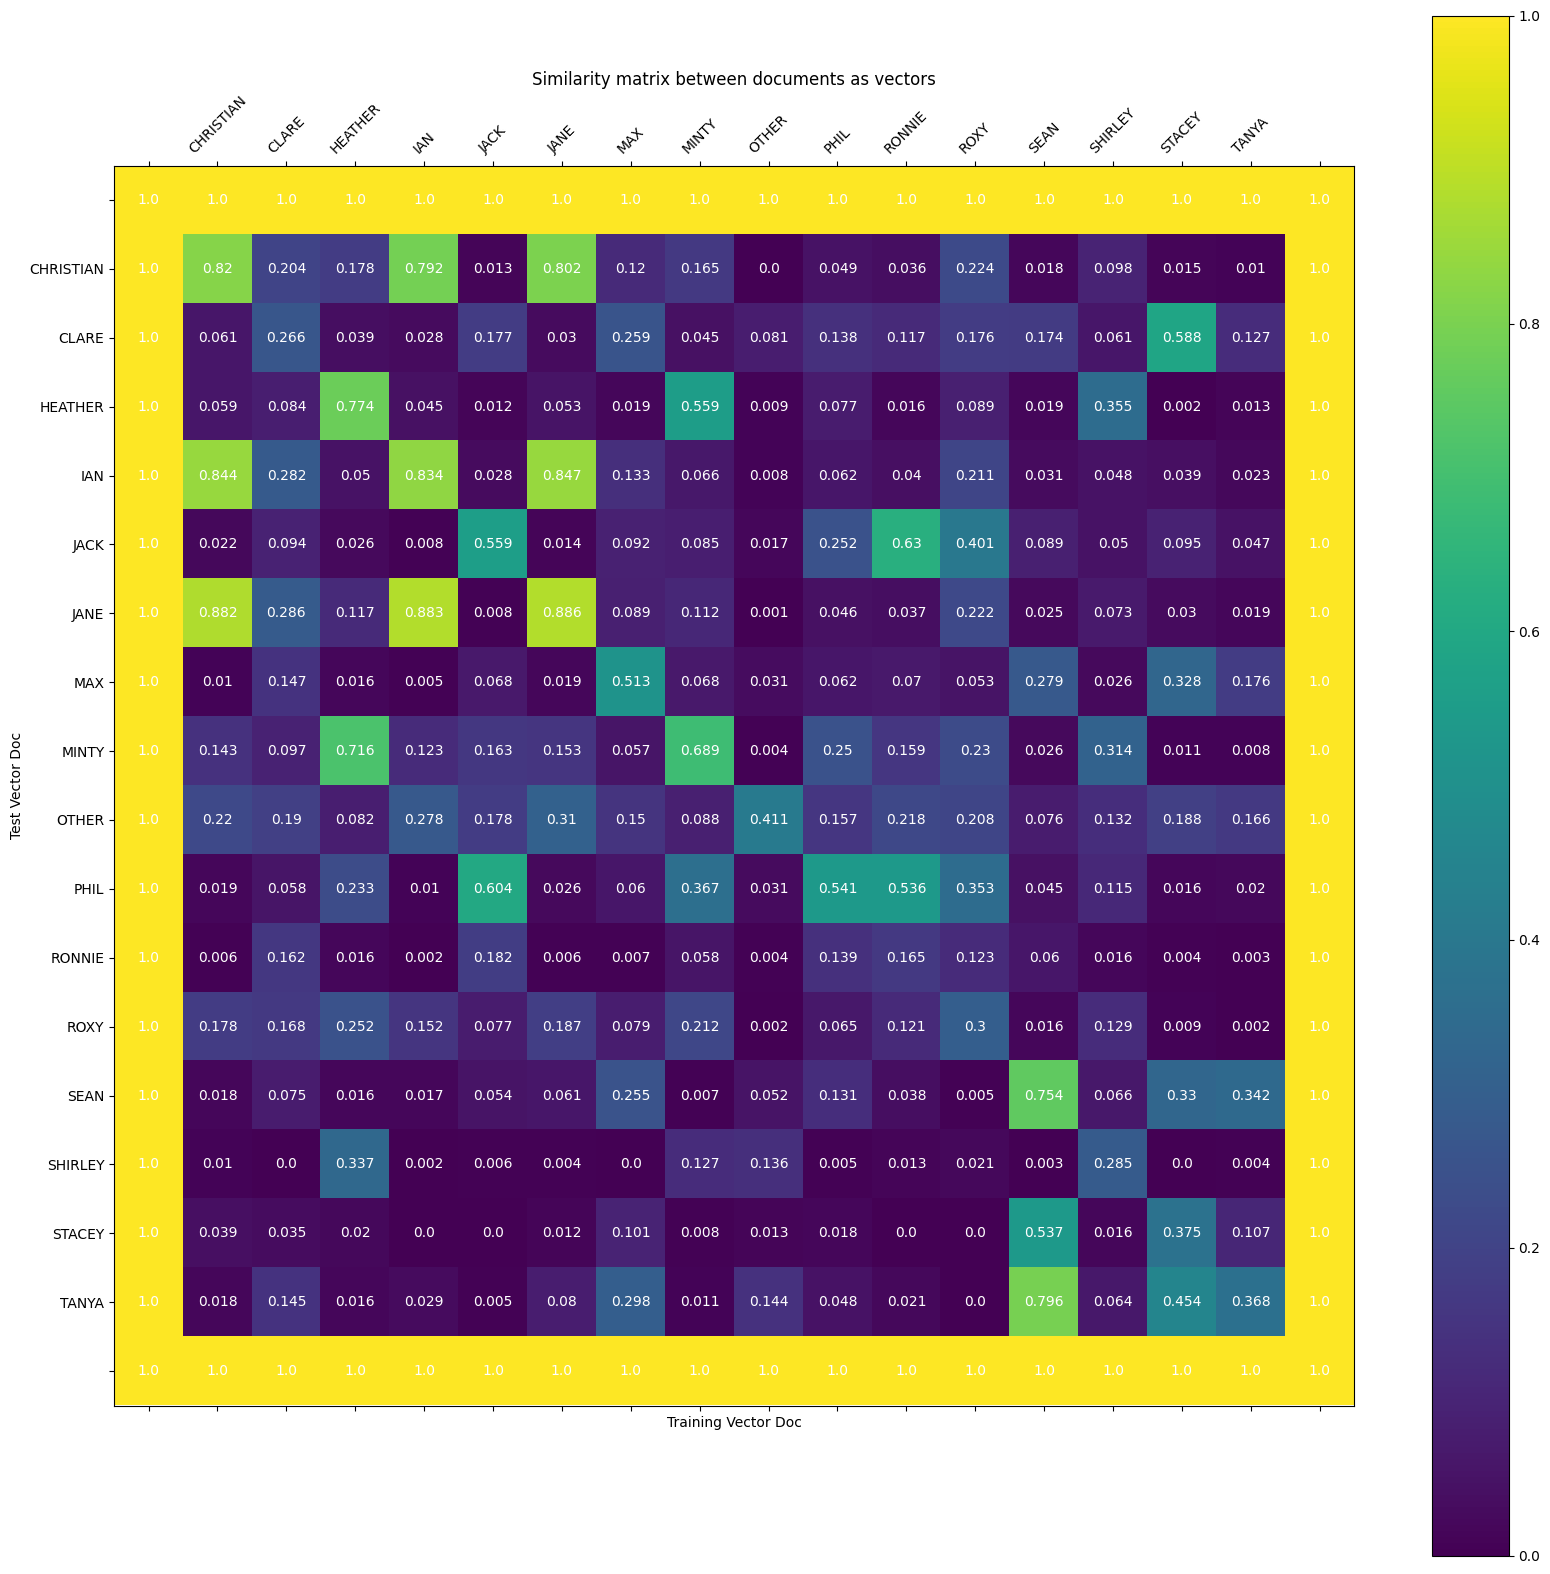

Validation Doc: JANE
Closest non-self matches:
  doc2=IAN, similarity=0.883

Furthest matches:
  doc2=OTHER, similarity=0.001

Validation Doc: IAN
Closest non-self matches:
  doc2=JANE, similarity=0.847

Furthest matches:
  doc2=OTHER, similarity=0.008

Validation Doc: CHRISTIAN
Closest non-self matches:
  doc2=JANE, similarity=0.802

Furthest matches:
  doc2=OTHER, similarity=0.000

Validation Doc: TANYA
Closest non-self matches:
  doc2=SEAN, similarity=0.796

Furthest matches:
  doc2=ROXY, similarity=0.000

Validation Doc: HEATHER
Closest non-self matches:
  doc2=MINTY, similarity=0.559

Furthest matches:
  doc2=STACEY, similarity=0.002

Validation Doc: SEAN
Closest non-self matches:
  doc2=TANYA, similarity=0.342

Furthest matches:
  doc2=ROXY, similarity=0.005

Validation Doc: MINTY
Closest non-self matches:
  doc2=HEATHER, similarity=0.716

Furthest matches:
  doc2=OTHER, similarity=0.004

Validation Doc: JACK
Closest non-self matches:
  doc2=RONNIE, similarity=0.630

Furthest mat

In [ ]:
# Grid Search on create_character_document_from_dataframe (Q3)

def create_character_document_from_dataframe(df, max_line_count, use_scene_context=True, context_mode="full_scene", neighbouring_line_count=2):


    df_sorted = df.sort_values(by=["Episode", "Scene"]) # We sort the dataframe by Episode and Scene. This ensures that the dialogues are processed in the correct order.

    grouped = df_sorted.groupby(["Episode", "Scene"], sort=False) # Grouping the sorted dataframe.

    character_docs = {} # Initializing dictionary to store aggregated dialogues for each character.
    character_line_count = {} # Initializing dictionary to store character lines for each character. It tracks the number of lines added per character to enforce the max_line_count limit.

    for (episode, scene), group_df in grouped: # We iterate over each scene group.

        lines = group_df["Line"].dropna().astype(str).str.strip().tolist() # We extract all the non empty dialogue lines and convert them to strings and remove the whitespaces.

        lines = [ln for ln in lines if ln] # Removing empty lines to ensure that only meaningful lines are processed.


        for position, (idx, row) in enumerate(group_df.iterrows()): # Iterating over each dialogue line within the current group, keeping track of the position.
            char_name = row["Character_name"] # We extract the name of the character speaking the line.
            line_text = row["Line"] # We extract the actual dialogue text.

            if not isinstance(line_text, str) or not line_text.strip(): # We skip preprocessing if the line is empty or not a string.
                continue

            # If the character is not already in the character_docs dictionary, we should initialize their entry.
            if char_name not in character_docs:
                character_docs[char_name] = "" # Initialize an empty string to store dialogues.
                character_line_count[char_name] = 0 # Initialize the line count for the character.

            # If the character has already reached the maximum number of lines, we skip adding more.
            if character_line_count[char_name] >= max_line_count:
                continue  # Skip if max lines reached.

            if use_scene_context:
                if context_mode == "full_scene":
                    context_text = " ".join(lines) # We add all lines in the scene to provide full context.
                elif context_mode == "partial_scene":
                    context_text = " ".join(lines[:5]) # We add only the first five lines of the scene for partial context.
                elif context_mode == "neighbouring_lines":
                    # Calculating the start and end indices to extract neighbouring lines around the current line.
                    start_idx = max(position - neighbouring_line_count, 0)  # Ensuring that the start_idx is not negative.
                    end_idx = min(position + neighbouring_line_count + 1, len(lines))  # Ensuring that the end_idx does not exceed list length.

                    context_lines = lines[start_idx:end_idx] # We are extracting the neighbouring lines based on the calculated indices.

                    context_text = " ".join(context_lines) # Combining the neighbouring lines into a single string.
                else:
                    context_text = " ".join(lines) # If an unknown context_mode is provided, default to full_scene context.
            else:
                context_text = "" # If use_scene_context is False, do not include any context.

            episode_scene_tokens = f"__EPISODE_{episode}__ __SCENE_{scene}__" # Creating tokens that identify the episode and scene.

            tokens_str = f"{episode_scene_tokens} {line_text}" # Combining the episode/scene tokens with the current line of dialogue.

            # Appending the determined context to the dialogue line based on the selected context_mode.
            if use_scene_context and context_mode in ["full_scene", "partial_scene", "neighbouring_lines"]:
                line_with_context = f"{tokens_str} {context_text} _EOL_ " # If scene context is used and the context_mode is recognized, include the context text.
            else:
                line_with_context = f"{tokens_str} _EOL_ " # If no context is used or the context_mode is unrecognized, append an end-of-line token.

            character_docs[char_name] += line_with_context # We add the processed line with or without context to the character's document.

            character_line_count[char_name] += 1 # Tracking the number of lines processed per character.

    print("Lines per character:", character_line_count)

    return character_docs



# Defining the parameter grid manually.
use_scene_context_options = [True, False]
context_mode_options = ["full_scene", "partial_scene", "neighbouring_lines"]
neighbouring_line_count_options = [1, 2]

best_parameters_q3 = None
best_mean_rank_q3 = float('inf')
best_df_eval_q3 = None
best_mean_cosine_similarity_q3 = 0
best_acc_q3 = 0


# Extracting the best parameters from Q1 and Q2.
do_lowercase_best = best_parameters_q1['do_lowercase']
remove_punct_best = best_parameters_q1['remove_punct']
remove_stopwords_best = best_parameters_q1['remove_stopwords']
do_lemmatize_best = best_parameters_q1['do_lemmatize']

use_bigrams_best = best_parameters_q2['use_bigrams']
use_trigrams_best = best_parameters_q2['use_trigrams']
use_pos_tags_best = best_parameters_q2['use_pos_tags']
k_features_best = best_parameters_q2['k_features']


# Iterating through all combinations of Q3 parameters.
for use_scene_context in use_scene_context_options:
    for context_mode in context_mode_options:
        if context_mode == "neighbouring_lines":
            for neighbouring_line_count in neighbouring_line_count_options:
                params = {
                    'use_scene_context': use_scene_context,
                    'context_mode': context_mode,
                    'neighbouring_line_count': neighbouring_line_count
                }
        else:
            params = {
                'use_scene_context': use_scene_context,
                'context_mode': context_mode
            }

        if context_mode == "neighbouring_lines":
            train_character_docs_variant = create_character_document_from_dataframe(df=train_data, max_line_count=300, use_scene_context=use_scene_context, context_mode=context_mode, neighbouring_line_count=params['neighbouring_line_count']) # Creating aggregated training character documents with current Q3 parameters.

        else:
            train_character_docs_variant = create_character_document_from_dataframe(df=train_data, max_line_count=300, use_scene_context=use_scene_context, context_mode=context_mode)

        training_corpus_variant = []
        for name, doc in sorted(train_character_docs_variant.items()):
            tokens = pre_process(doc, do_lowercase=do_lowercase_best, remove_punct=remove_punct_best, remove_stopwords=remove_stopwords_best, do_lemmatize=do_lemmatize_best) # Preprocessing training corpus with best Q1 parameters.
            training_corpus_variant.append((name, tokens))

        training_feature_matrix_variant = create_document_matrix_from_corpus(training_corpus_variant, fitting=True, use_bigrams=use_bigrams_best, use_trigrams=use_trigrams_best, use_pos_tags=use_pos_tags_best, k_features=k_features_best) # Creating feature matrix for training data with best Q2 parameters.

        if context_mode == "neighbouring_lines":
            val_character_docs_variant = create_character_document_from_dataframe(df=val_data, max_line_count=50, use_scene_context=use_scene_context, context_mode=context_mode, neighbouring_line_count=params['neighbouring_line_count']) # Creating aggregated validation character documents with current Q3 parameters.

        else:
            val_character_docs_variant = create_character_document_from_dataframe(df=val_data, max_line_count=50, use_scene_context=use_scene_context, context_mode=context_mode)

        val_corpus_variant = []
        for name, doc in sorted(val_character_docs_variant.items()):
            tokens = pre_process(doc, do_lowercase=do_lowercase_best, remove_punct=remove_punct_best, remove_stopwords=remove_stopwords_best, do_lemmatize=do_lemmatize_best) # Preprocessing validation corpus with best Q1 parameters.
            val_corpus_variant.append((name, tokens))

        val_feature_matrix_variant = create_document_matrix_from_corpus(val_corpus_variant, fitting=False, use_bigrams=use_bigrams_best, use_trigrams=use_trigrams_best, use_pos_tags=use_pos_tags_best, k_features=k_features_best) # Creating feature matrix for validation data with best Q2 parameters.


        mean_rank, mean_cos_sim, acc, df_eval = compute_IR_evaluation_scores(
            training_feature_matrix_variant,
            val_feature_matrix_variant,
            [t[0] for t in training_corpus_variant],
            [t[0] for t in val_corpus_variant]
        )

        print(f"Params={params}, Mean Rank={mean_rank}")


        if mean_rank < best_mean_rank_q3:
            best_mean_rank_q3 = mean_rank
            best_mean_cosine_similarity_q3 = mean_cos_sim
            best_acc_q3 = acc
            best_parameters_q3 = params
            best_df_eval_q3 = df_eval

print("\nBest parameters for Q3:", best_parameters_q3)
print("Best mean rank (Q3):", best_mean_rank_q3)
print("Best mean cosine similarity (Q3):", best_mean_cosine_similarity_q3)
print("Best accuracy (Q3):", best_acc_q3)
plot_heat_map_similarity(best_df_eval_q3)

def analyze_closest_furthest(df_sim, top_k=1):

    df_sorted = df_sim.sort_values('similarity', ascending=False) # We are sorting dataframe by descending order of similarity.

    val_docs = df_sorted['doc1'].unique() # Getting a unique list of documents from doc1 column which represents the validation documents.
    for doc in val_docs:
        rows_for_doc = df_sorted[df_sorted['doc1'] == doc] # Filtering the sorted DataFrame to include only rows where doc1 matches the current validation document (doc).

        rows_for_doc = rows_for_doc[rows_for_doc['doc1'] != rows_for_doc['doc2']] # Removing rows where doc1 is the same as doc2.

        top_matches = rows_for_doc.head(top_k) # Here, we are selecting the top k closest non-self matches.
        bottom_matches = rows_for_doc.tail(top_k) # Since the DataFrame is sorted in descending order, the last rows represent the least similar documents. Hence, we select the bottom k furthest non-self matches.

        print(f"Validation Doc: {doc}")
        print("Closest non-self matches:")
        for _, row in top_matches.iterrows():
            print(f"  doc2={row['doc2']}, similarity={row['similarity']:.3f}\n") # We find the closest match.
        print("Furthest matches:")
        for _, row in bottom_matches.iterrows():
            print(f"  doc2={row['doc2']}, similarity={row['similarity']:.3f}") # We find the furthest match.
        print("")

analyze_closest_furthest(best_df_eval_q3, top_k=1)


# **Deployment**

Lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  60470
OTHER Number of Words:  44303
JACK Number of Words:  57217
RONNIE Number of Words:  47828
ROXY Number of Words:  48000
TANYA Number of Words:  47110
SEAN Number of Words:  47949
MAX Number of Words:  55051
IAN Number of Words:  59186
JANE Number of Words:  56083
STACEY Number of Words:  51051
PHIL Number of Words:  61594
HEATHER Number of Words:  54807
MINTY Number of Words:  56835
CHRISTIAN Number of Words:  56427
CLARE Number of Words:  52777
total words 856688
Lines per character: {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}

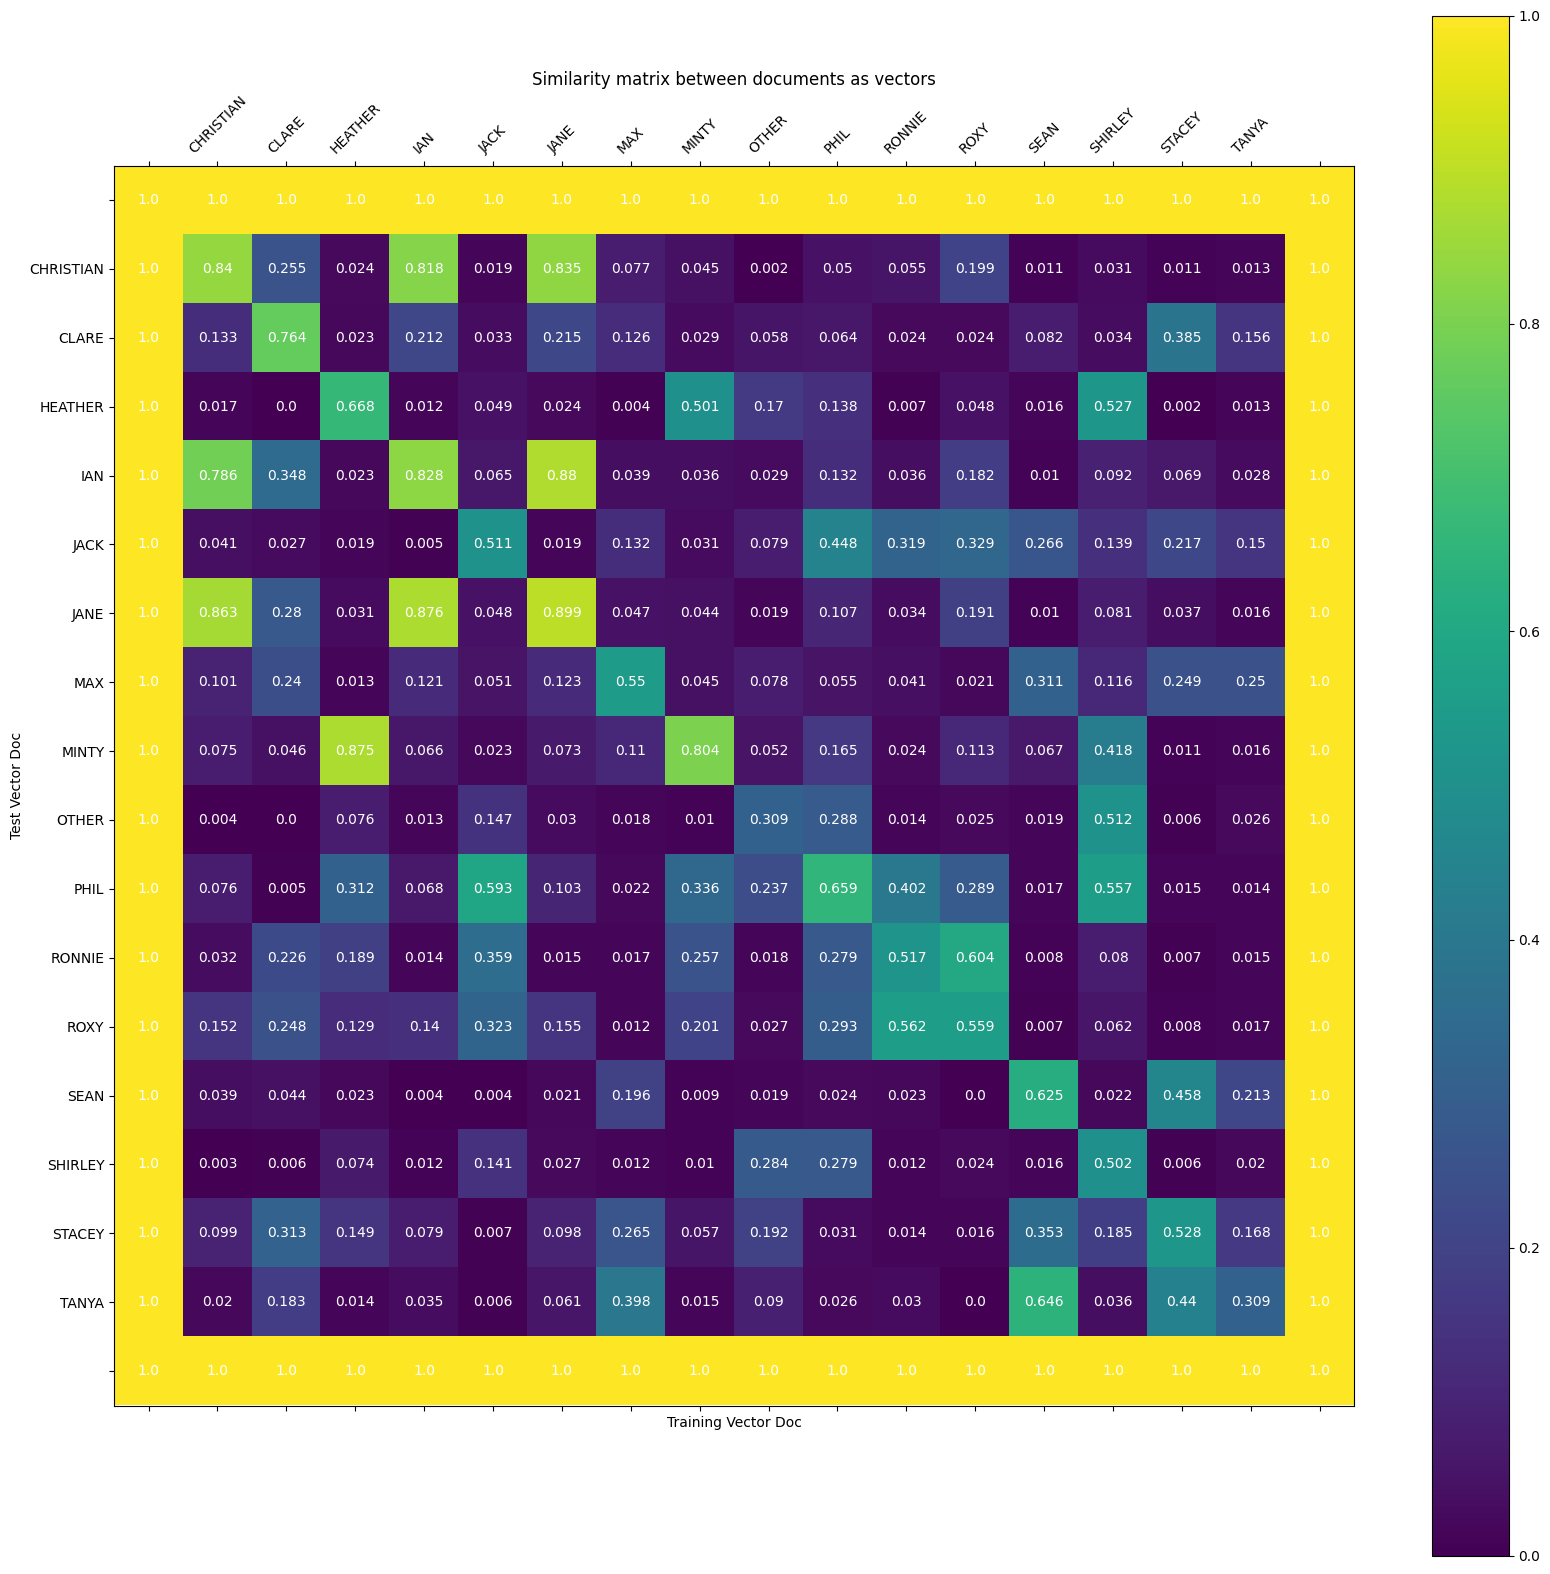

In [ ]:
# Final Training and Testing Pipeline

# Aggregate training character documents with the first 300 lines per character
train_character_docs = create_character_document_from_dataframe(df=train_data, max_line_count=300, use_scene_context=best_parameters_q3['use_scene_context'], context_mode=best_parameters_q3['context_mode'])
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

# Create the training corpus
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, _ in training_corpus]

# Vectorize the training corpus using best Q2 parameters
training_feature_matrix = create_document_matrix_from_corpus(corpus=training_corpus, fitting=True, use_bigrams=best_parameters_q2['use_bigrams'], use_trigrams=best_parameters_q2['use_trigrams'], use_pos_tags=best_parameters_q2['use_pos_tags'], k_features=best_parameters_q2['k_features'])

# Aggregate testing character documents with the first 50 lines per character
test_character_docs = create_character_document_from_dataframe(df=test_data, max_line_count=50, use_scene_context=best_parameters_q3['use_scene_context'], context_mode=best_parameters_q3['context_mode'])

test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=50)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# Create the testing corpus
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, _ in test_corpus]

# Vectorize the testing corpus using the same Q2 parameters (do not fit)
test_feature_matrix = create_document_matrix_from_corpus(corpus=test_corpus, fitting=False, use_bigrams=best_parameters_q2['use_bigrams'], use_trigrams=best_parameters_q2['use_trigrams'], use_pos_tags=best_parameters_q2['use_pos_tags'], k_features=best_parameters_q2['k_features'])

print("\n")
mean_rank, mean_cosine_similarity, accuracy, evaluation_df = compute_IR_evaluation_scores(
    training_feature_matrix,
    test_feature_matrix,
    train_labels,
    test_labels
)
plot_heat_map_similarity(evaluation_df)